# Updated notebook with the new Lavision library


Lavision released a new Python library to read their files, called lvreader, read below: 

"
LaVision's Python library lvreader got a new version 1.2.0 and extended its feature list by dedicated read/write functionalities for particle data sets. This makes it possible to further analyze your Shake-the-Box or PTV data with your own Python post-processing scripts. Whether you are interested in whole particle distributions or single particle tracks from your experimental data, lvreader lets you directly access DaVis set files without the need of a further export step.

Using the particle write functions, it is possible to import particle data from other sources and use DaVis' advanced processing operations, such as binning or fine-scale reconstruction, to gain further insights into your data.

If you are already working with the most recent Python version 3.10, the new release of lvreader supports it now as well. Click   https://www.lavision.de/en/downloads/software/index.php   to download lvreader 1.2.0." 

Or use the direct link https://www.lavision.de/en/download.php?id=4817




In [3]:
# !pip install /home/user/Downloads/lvreader-1.2.0/lvreader-1.2.0-cp38-cp38-linux_x86_64.whl
from pivpy import io, pivpy
from pivpy import graphics
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pathlib


In [8]:
from importlib import resources
filename = pathlib.Path(resources.files('pivpy') / "data" / "PIVMAT_jet" / "B00001.VC7")
ds = io.load_vc7(filename)

In [9]:
ds

<xarray.Dataset> Size: 395kB
Dimensions:  (y: 128, x: 128, t: 1)
Coordinates:
  * y        (y) float64 1kB 233.3 231.4 229.6 227.8 ... 3.029 1.187 -0.655
  * x        (x) float64 1kB -133.5 -131.6 -129.8 -127.9 ... 96.78 98.62 100.5
  * t        (t) float64 8B 1.0
Data variables:
    u        (y, x, t) float64 131kB -0.1296 -1.141 -0.8293 ... -3.417 0.0 0.0
    v        (y, x, t) float64 131kB -0.2803 -0.9105 -0.867 ... -19.63 0.0 0.0
    chc      (y, x, t) float64 131kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 0.0 0.0
Attributes: (2)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [pix]', ylabel='y [pix]'>)

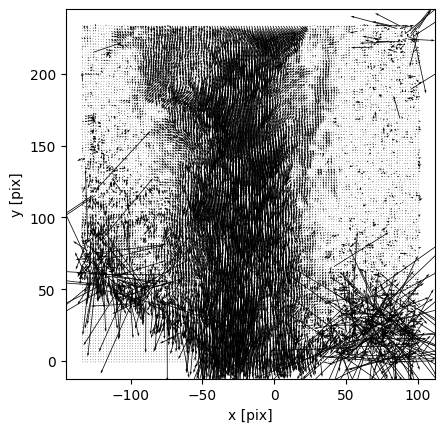

In [16]:
graphics.quiver(ds.isel(t=0),scalingFactor=200)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [pix]', ylabel='y [pix]'>)

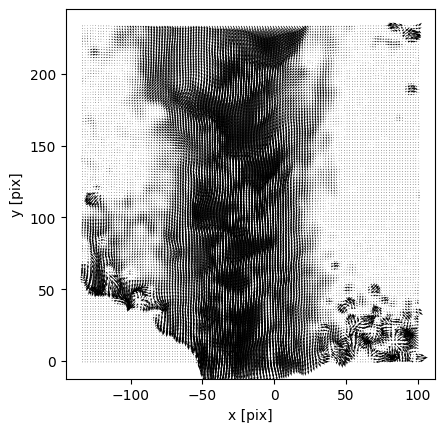

In [18]:
new = ds.piv.filterf()
graphics.quiver(new.isel(t=0),scalingFactor=200)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [pix]', ylabel='y [pix]'>)

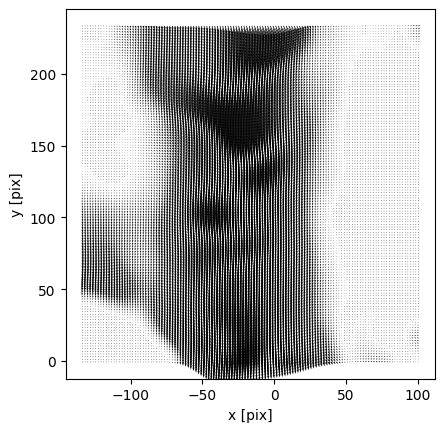

In [21]:
new = ds.piv.filterf([3,3,0])
graphics.quiver(new.isel(t=0),arrScale=200)

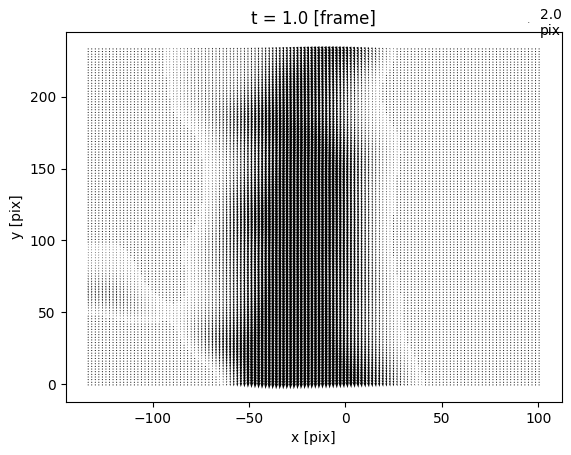

In [22]:
new.isel(t=0).plot.quiver(x='x',y='y',u='u',v='v')

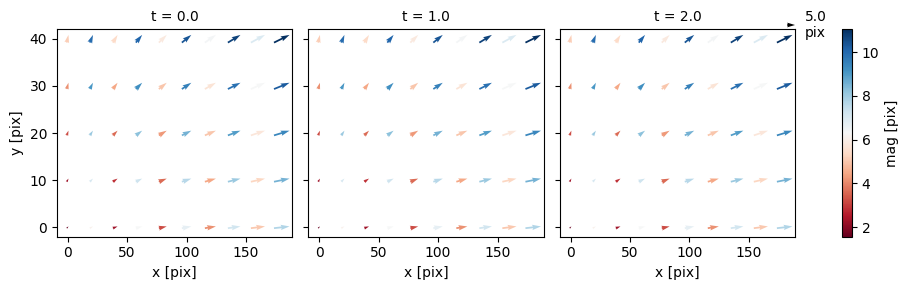

In [23]:
ds = io.create_sample_Dataset(n_frames=3,rows=5,cols=10)
ds = ds.piv.filterf([.5, .5, 0.])
ds["mag"] = np.hypot(ds["u"], ds["v"])
ds.plot.quiver(x='x',y='y',u='u',v='v',hue='mag',col='t',scale=150,cmap='RdBu')


In [25]:
# from https://github.com/kaipak/xrsigproc

from scipy.ndimage import gaussian_filter

def _get_dims(data):
    """Get primary x-y dimensions of dataset
    """
    return ('y', 'x')

def gaussian_smooth(data, sigma = [1., 1.], mask=False, mode='reflect'):
    """Apply gaussian kernel to convolution. Uses Scipy
       gaussian_filter method.
       Parameters:
       mode (str): {‘reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’}
                   What to do at edges of matrix input. See Scipy docs
                   for details on what these do.
    """
    dims = _get_dims(data)

    sc_gaussian_nd = lambda data: gaussian_filter(data, sigma, mode=mode)

    if mask:
        data_masked = data.where(data[mask_vars[dims]])
    else:
        data_masked = data.fillna(0.)

    return xr.apply_ufunc(sc_gaussian_nd, data_masked,
                          vectorize=True,
                          dask='parallelized',
                          input_core_dims = [dims],
                          output_core_dims = [dims],
                          # output_dtypes=[data.dtype]
                        )

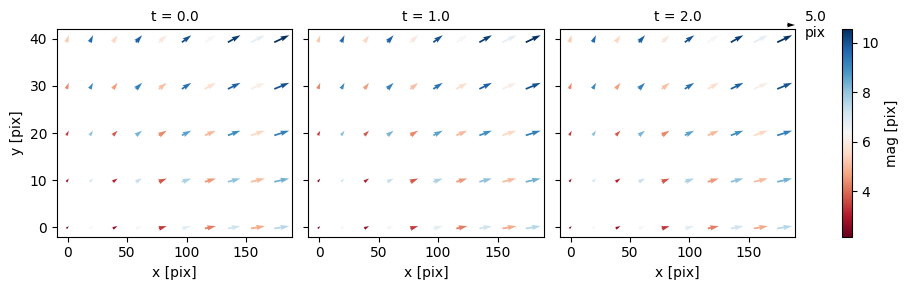

In [26]:
tmp = gaussian_smooth(ds)
tmp.plot.quiver(x='x',y='y',u='u',v='v',hue='mag',col='t',scale=150,cmap='RdBu')


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [pix]', ylabel='y [pix]'>)

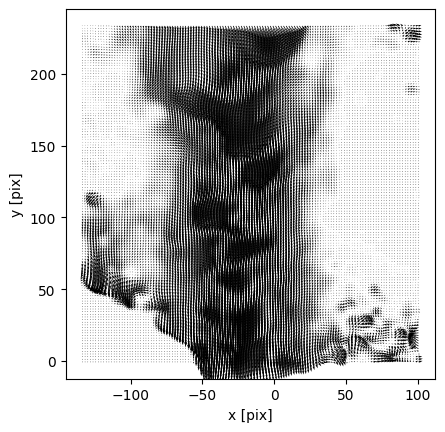

In [28]:
ds = io.load_vc7(filename)
new = gaussian_smooth(ds,sigma=[2., 2.])
# new.isel(t=0).plot.quiver(x='x',y='y',u='u',v='v')
graphics.quiver(new.isel(t=0), scalingFactor=200)
